## Data Analysis

In [111]:
import os
import dotenv

dotenv.load_dotenv()
DB_HOST = os.getenv('GP_DB_HOST')
DB_PORT = os.getenv('GP_DB_PORT')
DB_USER = os.getenv('GP_DB_USER')
DB_PASS = os.getenv('GP_DB_PASS')
DB_NAME = os.getenv('GP_DB_NAME')

conString = {'host':DB_HOST,
             'user':DB_USER,
             'dbname':DB_NAME,
             'password':DB_PASS,
             'port':DB_PORT}

# Data manipulation
import pandas as pd
import numpy as np
import psycopg2
import statsmodels

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import klib
import altair as alt
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

alt.data_transformers.disable_max_rows()  # disable error for big datasets

DataTransformerRegistry.enable('default')

Establishing Connection

In [172]:
conn = psycopg2.connect(**conString)
cur = conn.cursor()

Assigning Selected Countries

In [173]:
selected_countries = ['SGP','ESP','CHL','QAT','NZL','CHN','BGR','MEX','BRA','JOR','ZAF','SLV','IND','UKR','KEN','RWA','MLI','SEN', 'NPL','UZB']

selected_countries_str = str(selected_countries).removeprefix('[').removesuffix(']')


Getting the data from 2009 to 2018 for all countries

In [174]:
query = f'''SELECT ct.country_name, ei.country_code, ei.year, ei.val_qual_ed, hc.edu_pcnt_bud, hc.edu_pcnt_gdp, hc.hdi, hc.gdp_us, hc.gdp_percapita, hc.gdp_growth,income_grp, region
FROM edx.education_indicators AS ei INNER JOIN edx.human_capital AS hc ON ei.year = hc.year AND ei.country_code = hc.country_code
	INNER JOIN edx.country AS ct ON ct.country_code = ei.country_code
WHERE ei.year BETWEEN 2009 AND 2018 
ORDER BY ei.year DESC, ei.country_code'''

cur.execute(query= query)
edu_indicators = pd.DataFrame(cur.fetchall())
edu_indicators.columns = ['country_name', 'country_code' ,'year', 'val_qual_ed','edu_pcnt_gdp', 'edu_pcnt_bud','hdi','gdp_us','gdp_percapita','gdp_growth','income_grp','region']

Looking at the data

In [175]:
edu_indicators.head()

,country_name,country_code,year,val_qual_ed,edu_pcnt_gdp,edu_pcnt_bud,hdi,gdp_us,gdp_percapita,gdp_growth,income_grp,region
0,Aruba,ABW,2018,NaN,NaN,NaN,NaN,3.202189e+09,30253.279360,NaN,High income,Latin America & Caribbean
1,Africa Eastern and Southern,AFE,2018,NaN,17.01243,4.951635,NaN,1.011720e+12,1573.221585,2.461969,None,None
2,Islamic State of Afghanistan,AFG,2018,NaN,11.69606,3.199790,0.509,1.805323e+10,485.668419,1.189228,Low income,South Asia
3,Africa Western and Central,AFW,2018,NaN,16.33997,3.066335,NaN,7.416920e+11,1704.139603,2.952230,None,None
4,People's Republic of Angola,AGO,2018,NaN,5.41023,2.044700,0.582,1.013530e+11,3289.643995,-2.003630,Lower middle income,Sub-Saharan Africa


What does the data has

In [176]:
edu_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2650 entries, 0 to 2649
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   2650 non-null   object 
 1   country_code   2650 non-null   object 
 2   year           2650 non-null   int64  
 3   val_qual_ed    1255 non-null   float64
 4   edu_pcnt_gdp   1781 non-null   float64
 5   edu_pcnt_bud   1826 non-null   float64
 6   hdi            1630 non-null   float64
 7   gdp_us         2567 non-null   float64
 8   gdp_percapita  2567 non-null   float64
 9   gdp_growth     2535 non-null   float64
 10  income_grp     2160 non-null   object 
 11  region         2170 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 248.6+ KB


Visualize missing data in our overall dataset

GridSpec(6, 6)

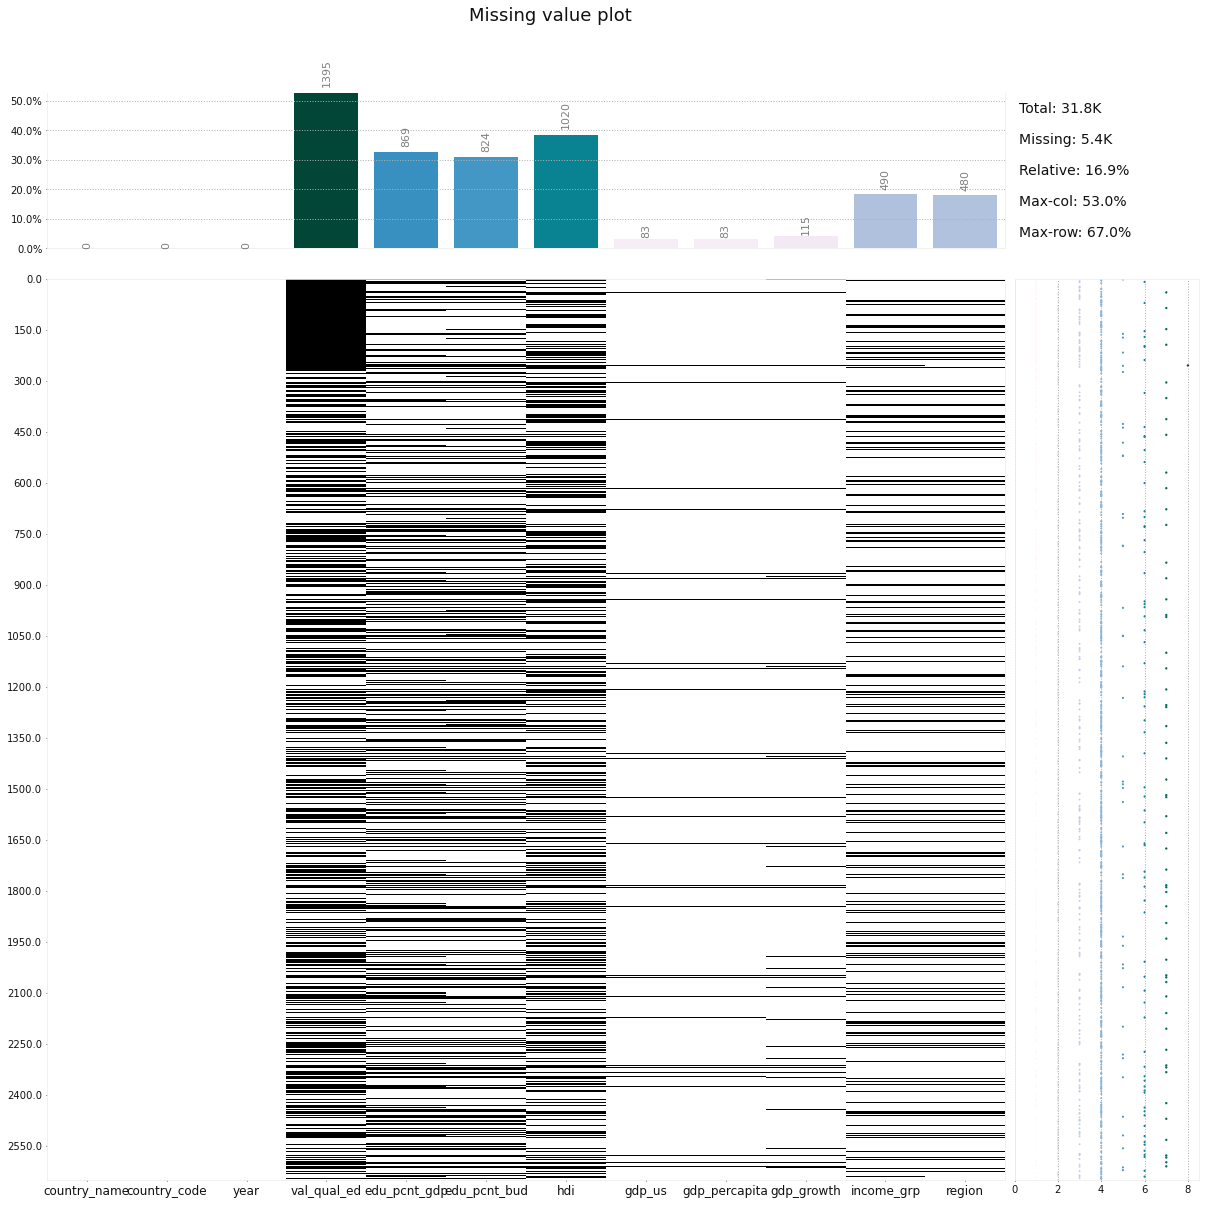

In [177]:
klib.missingval_plot(edu_indicators)

Build the cross sectional slice that we are interested in

In [178]:
edu_indicators_2017 = edu_indicators[edu_indicators['year']==2017]

Visualize the missing data in 2017 dataset

GridSpec(6, 6)

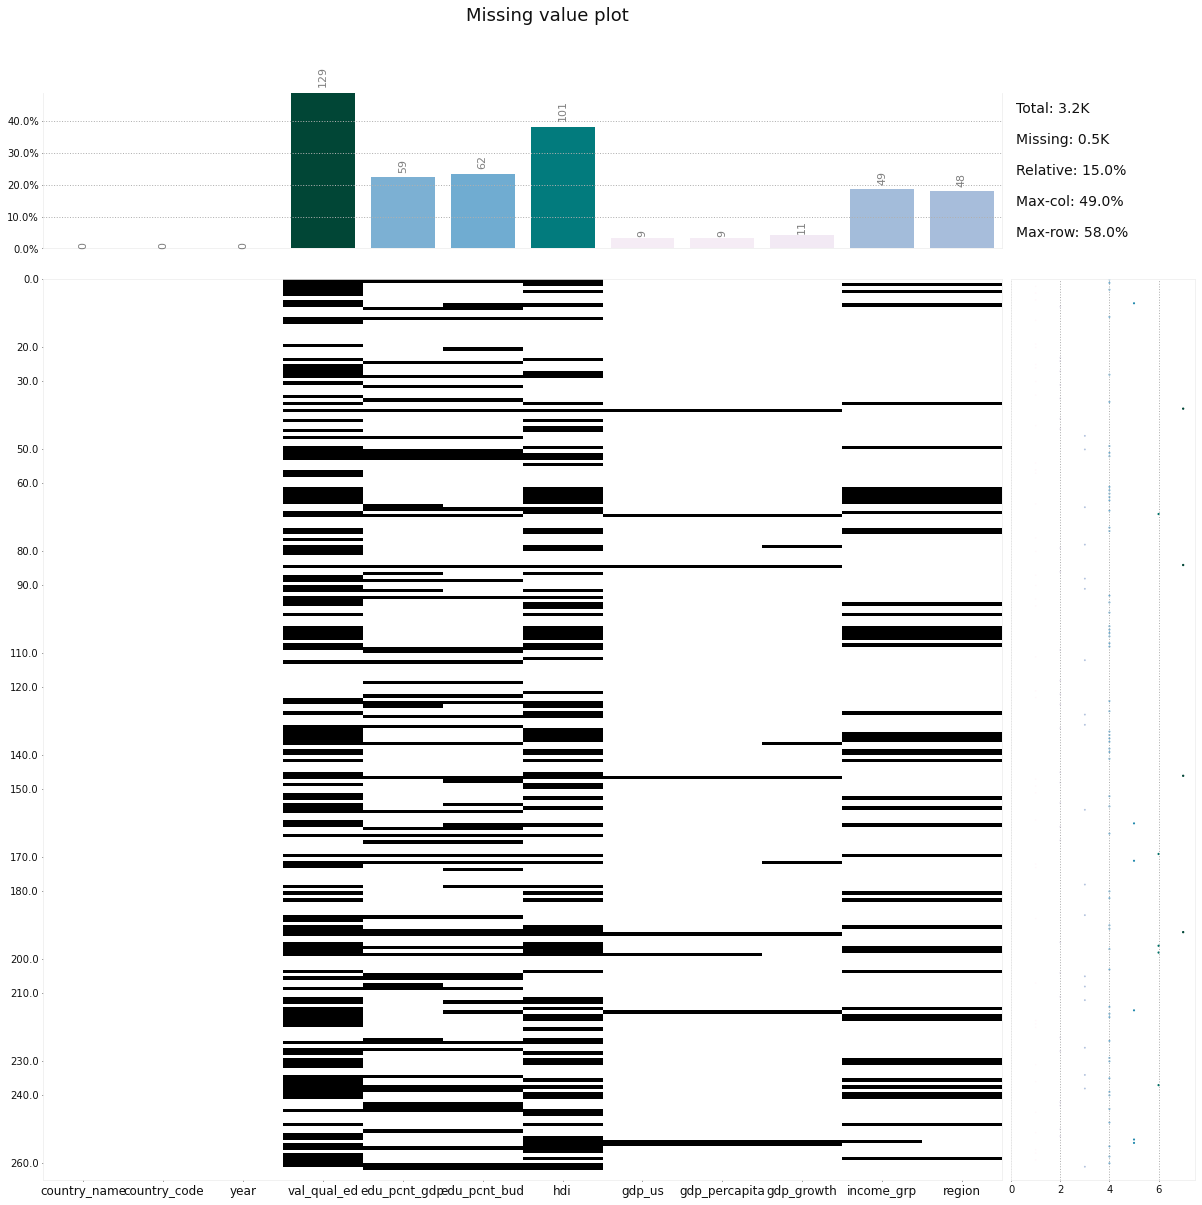

In [179]:
klib.missingval_plot(edu_indicators_2017)

### HERE WE SHOULD IMPUTE

In [120]:

fig = px.choropleth(locations=edu_indicators_2017['country_code'], 
                    locationmode="ISO-3",
                    color=edu_indicators_2017['income_grp'],
                    color_discrete_map={'High income':'Blue',
                                        'Upper middle income':'Green',
                                        'Lower middle income':'Orange',
                                        'Low income':'Red'},
                    scope="world"
                   )
fig.show()

### Bivariate data analysis

Text(0.5, 1.05, 'Quality of Education System')

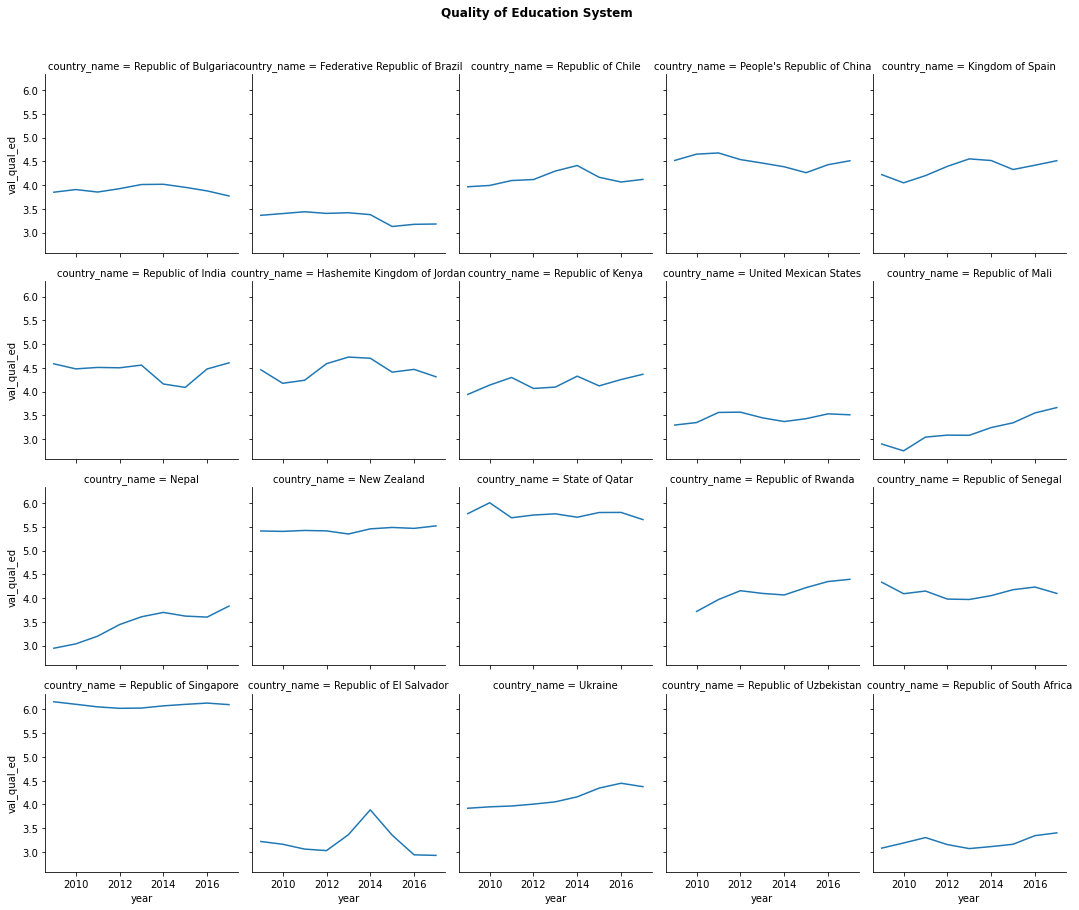

In [121]:
import seaborn as sns
g = sns.FacetGrid(edu_indicators, col='country_name', palette='Set1', col_wrap=5)
g.map_dataframe(sns.lineplot,'year', 'val_qual_ed')
g.fig.suptitle('Quality of Education System', y=1.05, fontweight='bold')

/var/folders/g2/rxrv5lvj0gzbd4fs1kyn5zgm0000gn/T/ipykernel_28086/2919615426.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



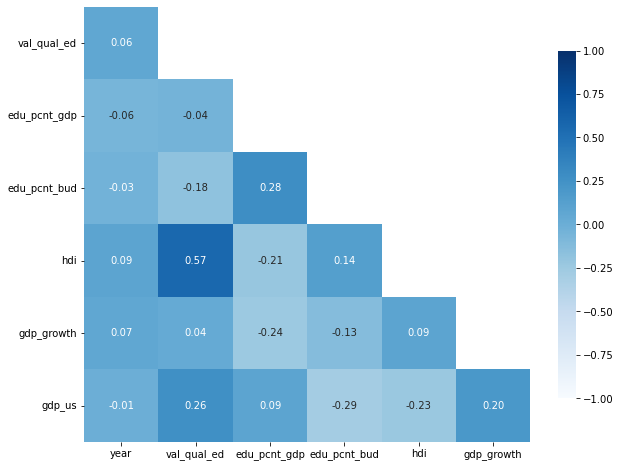

In [122]:
df_corr = edu_indicators.corr()

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

In [123]:
income_grp_ord = {'income_grp':['Low income','Lower middle income','Upper middle income','High income']}
regions_ord ={'region':['East Asia & Pacific', 'Middle East & North Africa', 'Latin America & Caribbean', 'Europe & Central Asia', 'Sub-Saharan Africa', 'South Asia']}


### Does the education expenditure as a % of the GDP correlate with increase in quality of education?


In [124]:
#Loading data
qu_gdp_qual = '''SELECT ct.country_code, ct.country_name,hc.year, edu_pcnt_bud, edu_pcnt_gdp, val_qual_ed,ct.income_grp,ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.human_capital as hc ON ei.year = hc.year and ei.country_code = hc.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = hc.country_code
WHERE edu_pcnt_gdp is not NULL and val_qual_ed is not NULL and hc.year BETWEEN 2008 and 2017'''

cur.execute(query=qu_gdp_qual)
df_gdp_qual = pd.DataFrame(cur.fetchall())

df_gdp_qual.columns = ['country_code','country_name','year','edu_pcnt_bud','edu_pcnt_gdp','val_qual_ed','income_grp','region']

df_gdp_qual = df_gdp_qual.dropna()

df_gdp_qual.head()

,country_code,country_name,year,edu_pcnt_bud,edu_pcnt_gdp,val_qual_ed,income_grp,region
0,AGO,People's Republic of Angola,2010,8.68477,3.42132,1.775528,Lower middle income,Sub-Saharan Africa
1,AGO,People's Republic of Angola,2011,8.95850,3.24377,1.708840,Lower middle income,Sub-Saharan Africa
2,AGO,People's Republic of Angola,2013,9.69356,3.87206,2.279704,Lower middle income,Sub-Saharan Africa
3,AGO,People's Republic of Angola,2014,7.13230,2.93055,2.202184,Lower middle income,Sub-Saharan Africa
4,ALB,Republic of Albania,2013,12.12391,3.53930,4.164543,Upper middle income,Europe & Central Asia


Let's first see in our year of interest (i.e. 2017) Whether there was any relationship

In [125]:
df_gdp_qual_2017 = df_gdp_qual[df_gdp_qual['year'] == 2017]

In [126]:
fig = px.scatter(data_frame=df_gdp_qual_2017,x='edu_pcnt_gdp',y='val_qual_ed',hover_name='country_name',color='val_qual_ed', trendline='ols')
fig.update_layout(
    title={
        'text': "Education Exp. (%GDP) and Education Quality",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Percentage of the GDP",
    yaxis_title="Education Quality Index"
)
fig.show()

That's surprising!! There's almost no correlation at all between the education expenditure as a % of the GDP and the Quality of Education. R^2 of 0.06.

Time to dig deeper!

Let's check if the income group has an interaction with the education expenditure (i.e. the change is affected by the income group )

In [127]:
fig = px.scatter(data_frame=df_gdp_qual_2017,x='edu_pcnt_gdp',y='val_qual_ed',facet_col='income_grp',hover_name='country_name',color='val_qual_ed', trendline='ols', category_orders=income_grp_ord)
fig.update_layout(
    title={
        'text': 'Education Exp. (% GDP) vs. Quality of Education By Income group',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='Percentage of the GDP',
    yaxis_title='Quality of Education Index'
)
fig.for_each_xaxis(lambda x: x.update(title = 'Percentage of the GDP'))
fig.show()

While the R2 across the different income groups is still low. We can see that the trend. It emphasis the gap; low income countries remain locked even if they increased the education expenditure and the high income increases as they increase the budget

Let's check if the tren holds when we add all the years as independent data points

In [128]:
px.scatter(data_frame=df_gdp_qual,x='edu_pcnt_gdp',y='val_qual_ed',color='val_qual_ed',hover_data=['country_name','year'],facet_col='income_grp',trendline='ols', category_orders=income_grp_ord)
fig.update_layout(
    title={
        'text': 'Education Exp. (% GDP) vs. Quality of Education By Income group',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='Percentage of the GDP',
    yaxis_title='Quality of Education Index'
)
fig.for_each_xaxis(lambda x: x.update(title = 'Percentage of the GDP'))
fig.show()

The trend is even further emphasised

Let's check if there are regional variation

In [129]:
fig = px.scatter(data_frame=df_gdp_qual_2017,x='edu_pcnt_gdp',y='val_qual_ed',color='val_qual_ed',hover_data=['country_name','year'],facet_col='region',trendline='ols', category_orders=regions_ord)
fig.update_layout(
    title={
        'text': 'Education Exp. (% GDP) vs. Quality of Education By Region',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='Percentage of the GDP',
    yaxis_title='Quality of Education Index'
)
fig.for_each_xaxis(lambda x: x.update(title = 'Percentage of the GDP'))
fig.show()

In [130]:
fig = px.scatter(data_frame=df_gdp_qual,x='edu_pcnt_gdp',y='val_qual_ed',color='val_qual_ed',hover_data=['country_name','year'],facet_col='region',trendline='ols',category_orders=regions_ord)
fig.update_layout(
    title={
        'text': 'Education Exp. (% GDP) vs. Quality of Education By Region',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='Percentage of the GDP',
    yaxis_title='Quality of Education Index'
)
fig.for_each_xaxis(lambda x: x.update(title = 'Percentage of the GDP'))
fig.show()

Let's check among our subset of representative countries if the change in the education expenditure as percent of the budget or the GDP had any correlation with the education quality across time

In [131]:
df_gdp_qual_selected_countries = df_gdp_qual[df_gdp_qual.country_code.isin(selected_countries)]

fig = px.line(df_gdp_qual_selected_countries,x='year',y= df_gdp_qual_selected_countries.columns[3:6],facet_col='country_name',facet_col_wrap=4,height=1600, facet_col_spacing=0.03)

fig.update_layout(
    title={
        'text': "Relationship between Budget, GDP and Education Quality by Country",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Year",
    yaxis_title="%"
)

fig.for_each_xaxis(lambda x: x.update(title = 'Year'))
fig.for_each_yaxis(lambda y: y.update(title = '%'))
fig.show()

### Does the increase in the quality of education improve social and economical welfare of people (HDI Index)?

In [132]:
qu_hdi_qual = '''SELECT ct.country_code, ct.country_name, hc.year, hdi, val_qual_ed, ct.income_grp, ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.human_capital as hc ON ei.year = hc.year and ei.country_code = hc.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = hc.country_code
WHERE hdi is not NULL and val_qual_ed is not NULL and hc.year BETWEEN 2008 and 2017'''

cur.execute(query=qu_hdi_qual)
df_hdi_qual = pd.DataFrame(cur.fetchall())

df_hdi_qual.columns = ['country_code','country_name','year','hdi','val_qual_ed','income_grp','region']

df_hdi_qual = df_hdi_qual.dropna()

df_hdi_qual

,country_code,country_name,year,hdi,val_qual_ed,income_grp,region
0,ALB,Republic of Albania,2008,0.728,3.290243,Upper middle income,Europe & Central Asia
1,DZA,People's Democratic Republic of Algeria,2008,0.702,2.814054,Lower middle income,Middle East & North Africa
2,ARG,Argentine Republic,2008,0.821,3.510129,Upper middle income,Latin America & Caribbean
3,ARM,Republic of Armenia,2008,0.745,3.062006,Upper middle income,Europe & Central Asia
4,AUS,Commonwealth of Australia,2008,0.926,5.373493,High income,East Asia & Pacific
...,...,...,...,...,...,...,...
1220,GBR,United Kingdom of Great Britain and Northern I...,2017,0.926,5.246218,High income,Europe & Central Asia
1221,USA,United States of America,2017,0.924,5.697491,High income,North America
1222,URY,Oriental Republic of Uruguay,2017,0.814,3.902377,High income,Latin America & Caribbean
1223,ZMB,Republic of Zambia,2017,0.578,3.609120,Lower middle income,Sub-Saharan Africa


In [133]:
df_hdi_qual_2017 = df_hdi_qual[df_hdi_qual['year'] == 2017]

In [134]:
fig = px.scatter(data_frame=df_hdi_qual_2017,x='val_qual_ed',y='hdi',hover_name='country_name',color='hdi', trendline='ols')

fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Country",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education",
    yaxis_title="Human Development Index (HDI)"
)
fig.show()

In [135]:
fig = px.scatter(data_frame=df_hdi_qual_2017,x='val_qual_ed',y='hdi',facet_col='income_grp',hover_name='country_name',color='hdi',trendline='ols', category_orders= income_grp_ord)
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group in 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education",
    yaxis_title="Human Development Index (HDI)"
)
fig.for_each_xaxis(lambda x: x.update(title="Quality of Education Index"))
fig.show()

In [136]:
fig = px.scatter(data_frame=df_hdi_qual,x='val_qual_ed',y='hdi',facet_col='income_grp',hover_name='country_name',color='hdi',trendline='ols', category_orders=income_grp_ord)
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group between 2008 and 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education Index",
    yaxis_title="Human Development Index (HDI)"
)
fig.for_each_xaxis(lambda x: x.update(title="Quality of Education Index"))
fig.show()

In [137]:
fig = px.scatter(data_frame=df_hdi_qual_2017,x='val_qual_ed',y='hdi',facet_col='region',hover_name='country_name',color='hdi',trendline='ols', category_orders= regions_ord)
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group in 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education Index",
    yaxis_title="Human Development Index (HDI)"
)
fig.for_each_xaxis(lambda x: x.update(title="Quality of Education Index"))
fig.show()

In [138]:
fig = px.scatter(data_frame=df_hdi_qual,x='val_qual_ed',y='hdi',facet_col='region',hover_name='country_name',color='hdi',trendline='ols', category_orders= regions_ord)
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group in 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education Index",
    yaxis_title="Human Development Index (HDI)"
)
fig.for_each_xaxis(lambda x: x.update(title="Quality of Education Index"))
fig.show()

In [139]:
df_hdi_qual_selected_countries = df_hdi_qual[df_hdi_qual.country_code.isin(selected_countries)]

fig = px.line(df_hdi_qual_selected_countries,x='year',y= df_hdi_qual_selected_countries.columns[3:5],facet_col='country_name',facet_col_wrap=4,height=1600, facet_col_spacing=0.03)

fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group Between 2008 and 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Year",
    yaxis_title="Index"
)
fig.for_each_xaxis(lambda x: x.update(title="Year"))
fig.for_each_yaxis(lambda y: y.update(title="Index"))
fig.show()

### Do scores in international standardized tests provide a good indicator of the quality of education?

We will use PISA as an example of the international standardized tests. 

In [140]:
qu_scores_qual = '''SELECT ct.country_code, ct.country_name, ps.year, ps.pisamath,ps.pisasci, ps.pisaread, val_qual_ed, ct.income_grp, ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.pisa_scores as ps ON ei.year = ps.year and ei.country_code = ps.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = ei.country_code
WHERE val_qual_ed is not NULL and ps.year BETWEEN 2000 and 2020 '''

cur.execute(query=qu_scores_qual)
df_scores_qual = pd.DataFrame(cur.fetchall())

df_scores_qual = df_scores_qual.dropna()

df_scores_qual.columns = ['country_code','country_name', 'year', 'pisa_math','pisa_science','pisa_reading','val_qual_ed','income_grp','region']

df_scores_qual

,country_code,country_name,year,pisa_math,pisa_science,pisa_reading,val_qual_ed,income_grp,region
0,AUS,Commonwealth of Australia,2009,514.0,527.0,515.0,5.171065,High income,East Asia & Pacific
1,AUS,Commonwealth of Australia,2012,504.0,521.0,512.0,5.300962,High income,East Asia & Pacific
2,AUS,Commonwealth of Australia,2015,494.0,510.0,503.0,5.338691,High income,East Asia & Pacific
3,AUT,Republic of Austria,2012,506.0,506.0,490.0,4.914795,High income,Europe & Central Asia
4,AUT,Republic of Austria,2015,497.0,495.0,485.0,4.785561,High income,Europe & Central Asia
...,...,...,...,...,...,...,...,...,...
112,TUR,Republic of Turkey,2012,448.0,463.0,475.0,3.757946,Upper middle income,Europe & Central Asia
113,TUR,Republic of Turkey,2015,420.0,425.0,428.0,3.687091,Upper middle income,Europe & Central Asia
114,USA,United States of America,2009,487.0,502.0,500.0,5.277301,High income,North America
115,USA,United States of America,2012,481.0,497.0,498.0,5.032046,High income,North America


Which countries are particpating in the PISA test?

In [141]:
fig = px.choropleth(locations=df_scores_qual['country_code'], 
                    locationmode="ISO-3",
                    color=df_scores_qual['income_grp'],
                    color_discrete_map={'High income':'Blue',
                                       'Upper middle income':'Green',
                                       'Lower middle income':'Orange',
                                       'Low income':'Red'},
                    scope="world"
                   )

fig.show()

We can see from the graph that participants of PISA are generally high income and upper middle income ... !!!! INEQUALITY!!!!

Let's see if there are any trends in the PISA scores.

In [142]:
fig = px.scatter(data_frame=df_scores_qual,x='pisa_math',y='pisa_science',facet_col='year',hover_name='country_name',color='pisa_reading',trendline='ols', facet_col_wrap=3)

fig.update_layout(
    title={
        'text': 'Correlation among PISA categories scores',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='PISA Math Score',
    yaxis_title='PISA Science Score',
    legend={'title':'PISA Reading Score'}
)
fig.for_each_xaxis(lambda x: x.update(title="PISA Math Score"))

Ok the scores are highly correlated R2 of 0.93 with each other throughout all the testing years. So it is safe to combine them without losing any explainability.

We'll create 1 metric that combines all the scores together to perform our analysis.

In [143]:
df_scores_qual['pisa_combined_score'] = df_scores_qual.apply(lambda row: row['pisa_math'] + row['pisa_science'] + row['pisa_reading'],axis=1)
df_scores_qual

,country_code,country_name,year,pisa_math,pisa_science,pisa_reading,val_qual_ed,income_grp,region,pisa_combined_score
0,AUS,Commonwealth of Australia,2009,514.0,527.0,515.0,5.171065,High income,East Asia & Pacific,1556.0
1,AUS,Commonwealth of Australia,2012,504.0,521.0,512.0,5.300962,High income,East Asia & Pacific,1537.0
2,AUS,Commonwealth of Australia,2015,494.0,510.0,503.0,5.338691,High income,East Asia & Pacific,1507.0
3,AUT,Republic of Austria,2012,506.0,506.0,490.0,4.914795,High income,Europe & Central Asia,1502.0
4,AUT,Republic of Austria,2015,497.0,495.0,485.0,4.785561,High income,Europe & Central Asia,1477.0
...,...,...,...,...,...,...,...,...,...,...
112,TUR,Republic of Turkey,2012,448.0,463.0,475.0,3.757946,Upper middle income,Europe & Central Asia,1386.0
113,TUR,Republic of Turkey,2015,420.0,425.0,428.0,3.687091,Upper middle income,Europe & Central Asia,1273.0
114,USA,United States of America,2009,487.0,502.0,500.0,5.277301,High income,North America,1489.0
115,USA,United States of America,2012,481.0,497.0,498.0,5.032046,High income,North America,1476.0


In [144]:
fig = px.scatter(data_frame=df_scores_qual,x='pisa_combined_score',y='val_qual_ed',facet_col='year',hover_name='country_name',color='val_qual_ed',trendline='ols')
fig.update_layout(
    title={
        'text': 'Relationship between PISA combined score vs. Quality of Education Index',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='PISA Combined Score',
    yaxis_title='Quality of Educaiton Index',
    legend={'title':'Quality of Education Index'}
)
fig.for_each_xaxis(lambda x: x.update(title="PISA Combined Score"))
fig.show()

In [150]:
fig = px.scatter(data_frame=df_scores_qual,x='pisa_combined_score',y='val_qual_ed',hover_name='country_name',color='year',trendline='ols')
fig.update_layout(
    title={
        'text': 'Relationship between PISA combined score vs. Quality of Education Index between 2008 and 2017',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='PISA Combined Score',
    yaxis_title='Quality of Educaiton Index'
)
fig.for_each_xaxis(lambda x: x.update(title="PISA Combined Score"))
fig.show()

### Does the increase in the quality of education result in an increase in the living standards of the people (GDP)?

In [146]:
df_qual_gpc = '''SELECT ct.country_code, ct.country_name, hc.year, gdp_percapita,gdp_us, val_qual_ed, ct.income_grp, ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.human_capital as hc ON ei.year = hc.year and ei.country_code = hc.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = hc.country_code
WHERE hdi is not NULL and val_qual_ed is not NULL and hc.year BETWEEN 2008 and 2017'''

cur.execute(query=df_qual_gpc)
df_qual_gpc = pd.DataFrame(cur.fetchall())

df_qual_gpc.columns = ['country_code','country_name','year','gdp_percapita', 'gdp_us','val_qual_ed','income_grp','region']

df_qual_gpc

,country_code,country_name,year,gdp_percapita,gdp_us,val_qual_ed,income_grp,region
0,ALB,Republic of Albania,2008,4370.539925,1.288135e+10,3.290243,Upper middle income,Europe & Central Asia
1,DZA,People's Democratic Republic of Algeria,2008,4923.631615,1.710010e+11,2.814054,Lower middle income,Middle East & North Africa
2,ARG,Argentine Republic,2008,9020.873323,3.615580e+11,3.510129,Upper middle income,Latin America & Caribbean
3,ARM,Republic of Armenia,2008,4010.861381,1.166204e+10,3.062006,Upper middle income,Europe & Central Asia
4,AUS,Commonwealth of Australia,2008,49654.910600,1.055130e+12,5.373493,High income,East Asia & Pacific
...,...,...,...,...,...,...,...,...
1220,GBR,United Kingdom of Great Britain and Northern I...,2017,40857.755580,2.699020e+12,5.246218,High income,Europe & Central Asia
1221,USA,United States of America,2017,60109.655730,1.954300e+13,5.697491,High income,North America
1222,URY,Oriental Republic of Uruguay,2017,18690.893840,6.423397e+10,3.902377,High income,Latin America & Caribbean
1223,ZMB,Republic of Zambia,2017,1535.196574,2.587360e+10,3.609120,Lower middle income,Sub-Saharan Africa


In [147]:
df_qual_gpc_2017 = df_qual_gpc[df_qual_gpc['year']==2017]

In [151]:
fig = px.scatter(data_frame=df_qual_gpc_2017,x='gdp_percapita',y='val_qual_ed',hover_name='country_name',color='val_qual_ed',trendline='ols',log_x=True)
fig.update_layout(
    title={
        'text': 'Relationship between GDP per Capita combined score vs. Quality of Education Index in 2017',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='GDP per Capita',
    yaxis_title='Quality of Educaiton Index',
    legend={'title':'Quality of Education Index'}
)
fig.for_each_xaxis(lambda x: x.update(title="GDP per Capita"))
fig.show()

In [152]:
fig = px.scatter(data_frame=df_qual_gpc,x='gdp_percapita',y='val_qual_ed',hover_name='country_name',color='val_qual_ed',trendline='ols',log_x=True)
fig.update_layout(
    title={
        'text': 'Relationship between GDP per Capita combined score vs. Quality of Education Index between 2008 and 2017',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='GDP per Capita',
    yaxis_title='Quality of Educaiton Index',
    legend={'title':'Quality of Education Index'}
)
fig.for_each_xaxis(lambda x: x.update(title="GDP per Capita"))
fig.show()

### Closing Connection

In [ ]:
conn.close()